# Debugging `Loss_PDE` for the Helmholtz Equation

This notebook is designed to help debug the `Loss_PDE` class, specifically its usage with `Helmholtz_loss` for the 'helmholtz' dataset. It supports both CNO models trained with `TrainPINO_CNO.py` and FNO models trained with `TrainPINO_FNO.py`. The model type is automatically detected based on the model path.

## Helmholtz Equation
The Helmholtz equation solved is: ∇²u + ω²a²u = 0
- Rearranged: $$∇²u = -ω²a²u$$  
- Where $ω = 5π/2$, $a(x,y)$ is the coefficient field, $u(x,y)$ is the solution


## 1. Setup

First, we import the necessary libraries and add the project's root directory to the system path to ensure all modules can be found.


In [5]:
import sys
import os
import torch
import pandas as pd
import json
import matplotlib.pyplot as plt
import numpy as np

# Add parent directory to path to import project modules
if '..' not in sys.path:
    sys.path.append('..')

from Problems.CNOBenchmarks import Helmholtz as CNO_Helmholtz
from Problems.FNOBenchmarks import Helmholtz as FNO_Helmholtz
from Physics_NO.loss_functions.ModulePDELoss import Loss_PDE, Helmholtz_loss, Laplace, Unnormalize


## 2. Configuration and Parameters

We'll define the parameters for our debugging session. These are taken from the PINO training scripts for the Helmholtz example. The notebook will automatically detect whether the model is CNO or FNO and use the appropriate data loader.


In [6]:
# Model configuration - works with both CNO and FNO models
# For CNO models: use paths like "../TrainedModels/CNO_1024helmholtz" 
# For FNO models: use paths like "../TrainedModels/FNO_1024helmholtz"
InfoPretrainedNetwork = {
    "Path to pretrained model": "../TrainedModels/helmholtz/PINO+_FNO_no_pretraininghelmholtz_1", 
    "Pretrained Samples":  1024,
}

training_properties = {
    "learning_rate": 0.0003, 
    "weight_decay": 1e-10,
    "scheduler_step": 10,
    "scheduler_gamma": 0.98,
    "epochs": 100,
    "batch_size": 16,
    "exp": 1, # L1 error
    "training_samples": 1024,
    "pde_decay": 1,
    "boundary_decay": 100,
    "pad_factor": 0
}

which_example = 'helmholtz'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Detect model type based on path
def detect_model_type(model_path):
    """Detect whether the model is CNO or FNO based on the path or architecture file."""
    if 'CNO' in model_path or 'cno' in model_path:
        return 'CNO'
    elif 'FNO' in model_path or 'fno' in model_path:
        return 'FNO'
    else:
        # Check architecture file if path doesn't contain type info
        arch_path = os.path.join(model_path, 'net_architecture.txt')
        if os.path.exists(arch_path):
            df = pd.read_csv(arch_path, header=None, index_col=0)
            arch_dict = df.to_dict()[1]
            if 'in_size' in arch_dict:
                return 'CNO'
            elif 'width' in arch_dict:
                return 'FNO'
        
        # Default fallback
        print("Warning: Could not detect model type from path. Assuming CNO.")
        return 'CNO'

model_type = detect_model_type(InfoPretrainedNetwork["Path to pretrained model"])
print(f"Detected model type: {model_type}")


Using device: cpu
Detected model type: FNO


### Example Usage

To test with different models, simply change the model path:

**For CNO models:**
```python
InfoPretrainedNetwork["Path to pretrained model"] = "../TrainedModels/CNO_1024helmholtz"
```

**For FNO models:**
```python
InfoPretrainedNetwork["Path to pretrained model"] = "../TrainedModels/FNO_1024helmholtz"
```

**For PINO models (physics-informed):**
```python
InfoPretrainedNetwork["Path to pretrained model"] = "../TrainedModels/PINO_CNO_pretrainedhelmholtz"
InfoPretrainedNetwork["Path to pretrained model"] = "../TrainedModels/PINO_FNO_pretrainedhelmholtz"
```

**Note! FNO Loader and Model natively use (batch_dim, grid, grid, channel), whereas CNO uses (batch_dim, channel, grid, grid)**


In [7]:
# Helper functions for dimension conversion between FNO and CNO formats
def convert_fno_to_cno_format(x):
    """Convert FNO format (batch, height, width, channel) to CNO format (batch, channel, height, width)"""
    return x.permute(0, 3, 1, 2)

def convert_cno_to_fno_format(x):
    """Convert CNO format (batch, channel, height, width) to FNO format (batch, height, width, channel)"""
    return x.permute(0, 2, 3, 1)


## 3. Load Data and Model

The notebook will automatically detect the model type (CNO or FNO) and use the appropriate data loader and architecture parameters. This ensures compatibility with both model types while maintaining the same analysis workflow.


In [8]:
# Load model architecture from the pretrained model's directory
net_architecture_path = os.path.join(InfoPretrainedNetwork["Path to pretrained model"], 'net_architecture.txt')
df = pd.read_csv(net_architecture_path, header=None, index_col=0)
model_architecture_ = df.to_dict()[1]
model_architecture_ = {key: int(value) if str(value).isdigit() else float(value) if '.' in str(value) else value for key, value in df.to_dict()[1].items()}

# Get the appropriate size parameter based on model type
if model_type == 'CNO':
    in_size = model_architecture_["in_size"]
elif model_type == 'FNO':
    in_size = model_architecture_["width"]  # FNO uses 'width' instead of 'in_size'
    
print(f"Grid size: {in_size}")

# Load data using appropriate class
if model_type == 'CNO':
    example = CNO_Helmholtz(
        network_properties=model_architecture_, 
        device=device, 
        batch_size=training_properties['batch_size'], 
        training_samples=training_properties['training_samples'],
        s=in_size,
        in_dist=True,  # In-distribution test data
        N_max=19675,   # Total samples in dataset
        cluster=True,  # Running on cluster
        pad_factor=training_properties['pad_factor']
    )
elif model_type == 'FNO':
    example = FNO_Helmholtz(
        network_properties=model_architecture_, 
        device=device, 
        batch_size=training_properties['batch_size'], 
        training_samples=training_properties['training_samples'],
        s=in_size,
        in_dist=True,  # In-distribution test data
        N_max=19675,   # Total samples in dataset
        cluster=True,  # Running on cluster
        pad_factor=training_properties['pad_factor']
    )

train_loader = example.train_loader

# Get normalization values from dataset
Normalization_values = train_loader.dataset.get_max_and_min()

# Load model
pretrained_model_path = os.path.join(InfoPretrainedNetwork["Path to pretrained model"], 'model.pkl')
model = torch.load(pretrained_model_path, map_location=device, weights_only=False)
if hasattr(model, 'device'):
    model.device = device
model = model.to(device)
model.eval()

print(f"Model type: {model_type}")
print(f"Architecture parameter: {in_size}")
print("Model and data loaded successfully.")


Grid size: 128
Model type: FNO
Architecture parameter: 128
Model and data loaded successfully.


## 4. Data Normalization Verification

Before we proceed with the loss calculation, let's verify that the data normalization and unnormalization are working correctly. This is crucial because the PDE loss requires unnormalized data, while the model works with normalized data.


In [9]:
# Get a batch and examine normalization
input_batch, label_batch = next(iter(train_loader))

# Convert FNO format to CNO format if needed
if model_type == 'FNO':
    print(f"Converting FNO data format:")
    print(f"  Original input shape: {input_batch.shape}")
    print(f"  Original label shape: {label_batch.shape}")
    input_batch = convert_fno_to_cno_format(input_batch)
    label_batch = convert_fno_to_cno_format(label_batch)
    print(f"  Converted input shape: {input_batch.shape}")
    print(f"  Converted label shape: {label_batch.shape}")

input_batch = input_batch.to(device)
label_batch = label_batch.to(device)

print("Normalization values from dataset:")
for key, value in Normalization_values.items():
    print(f"  {key}: {value}")

# Test unnormalization manually
unnormalize_fn = Unnormalize(which_example, Normalization_values)


Converting FNO data format:
  Original input shape: torch.Size([16, 128, 128, 2])
  Original label shape: torch.Size([16, 128, 128, 1])
  Converted input shape: torch.Size([16, 2, 128, 128])
  Converted label shape: torch.Size([16, 1, 128, 128])
Normalization values from dataset:
  mean_data: 1
  mean_model: 0.11523915668552
  std_model: 0.8279975746000605


In [10]:
# Get model prediction
with torch.no_grad():
    if model_type == 'FNO':
        # Convert input back to FNO format for the model
        model_input = convert_cno_to_fno_format(input_batch)
        model_output = model(model_input)
        # Convert output back to CNO format for the rest of the code
        output_pred_batch = convert_fno_to_cno_format(model_output)
        print(f"FNO model input shape: {model_input.shape}")
        print(f"FNO model output shape: {model_output.shape}")
        print(f"Converted output shape: {output_pred_batch.shape}")
    else:
        # CNO model works directly with CNO format
        output_pred_batch = model(input_batch)
        print(f"CNO model input shape: {input_batch.shape}")
        print(f"CNO model output shape: {output_pred_batch.shape}")


FNO model input shape: torch.Size([16, 128, 128, 2])
FNO model output shape: torch.Size([16, 128, 128, 1])
Converted output shape: torch.Size([16, 1, 128, 128])


In [11]:
# Simple debugging test: Check data shapes and ranges
print("=== Data Shape Verification ===")
print(f"Input batch shape: {input_batch.shape}")
print(f"Label batch shape: {label_batch.shape}")
print(f"Prediction batch shape: {output_pred_batch.shape}")

# Test unnormalization
input_un, label_un = unnormalize_fn(input=input_batch, output=label_batch)
_, output_pred_un = unnormalize_fn(input=input_batch, output=output_pred_batch)

print("n=== Normalized Statistics ===")
print(f"Input batch - Min: {input_batch.min().item():.6f}, Max: {input_batch.max().item():.6f}")
print(f"Label batch - Min: {label_batch.min().item():.6f}, Max: {label_batch.max().item():.6f}")
print(f"Prediction batch - Min: {output_pred_batch.min().item():.6f}, Max: {output_pred_batch.max().item():.6f}")

print("n=== Unnormalized Statistics ===")
print(f"Input unnorm - Min: {input_un.min().item():.6f}, Max: {input_un.max().item():.6f}")
print(f"Label unnorm - Min: {label_un.min().item():.6f}, Max: {label_un.max().item():.6f}")
print(f"Prediction unnorm - Min: {output_pred_un.min().item():.6f}, Max: {output_pred_un.max().item():.6f}")

print("n=== Verification Successful ===")
print("Data normalization and model prediction working correctly.")


=== Data Shape Verification ===
Input batch shape: torch.Size([16, 2, 128, 128])
Label batch shape: torch.Size([16, 1, 128, 128])
Prediction batch shape: torch.Size([16, 1, 128, 128])
n=== Normalized Statistics ===
Input batch - Min: 0.000000, Max: 1.000000
Label batch - Min: -3.997373, Max: 3.254719
Prediction batch - Min: -1.885588, Max: 2.679259
n=== Unnormalized Statistics ===
Input unnorm - Min: 1.000000, Max: 2.000000
Label unnorm - Min: -3.194576, Max: 2.810139
Prediction unnorm - Min: -1.446023, Max: 2.333659
n=== Verification Successful ===
Data normalization and model prediction working correctly.


## 5. Replicating the Training Loop's Helmholtz Loss Calculation

Now we get a single batch of data, pass it through the model, and calculate the Helmholtz physics-informed loss, just as it happens in the training loop of `TrainPINO_CNO.py` and `TrainPINO_FNO.py`.

**Recall the Helmholtz Equation:**
$$\nabla^2 u + \omega^2 a^2 u = 0$$

Rearranged: $$\nabla^2 u = -\omega^2 a^2 u$$

where $\omega = 5\pi/2$, $a(x,y)$ is the coefficient field (first channel of input), and $u(x,y)$ is the solution.


In [12]:
# Instantiate the loss function from the script
loss_pde_fn = Loss_PDE(which_example=which_example,
                         Normalization_values=Normalization_values,
                         p=training_properties['exp'],
                         pad_factor=training_properties['pad_factor'],
                         in_size=in_size,
                         force_fourier=True #! for debugging (sets the Loss to use fourier even if natively use fd)
                         )
print(loss_pde_fn)

# Calculate loss as in the script
loss_PDE, loss_boundary = loss_pde_fn(input=input_batch, output=output_pred_batch)

print(f"n=== Standard Helmholtz Loss Calculation ===")
print(f"  PDE Loss: {loss_PDE.item():.6f}")
print(f"  Boundary Loss: {loss_boundary.item():.6f}")
print(f"  Total Loss: {loss_PDE.item() + loss_boundary.item():.6f}")


Loss_PDE(
  (loss): Helmholtz_loss(
    (Laplace): Laplace()
    (loss): L1Loss()
  )
)
n=== Standard Helmholtz Loss Calculation ===
  PDE Loss: 85.553299
  Boundary Loss: 0.908955
  Total Loss: 86.462254


## 6. Debugging `Helmholtz_loss`

Here, we will manually perform the steps inside `Loss_PDE.forward` and `Helmholtz_loss.forward` to inspect the intermediate tensors. This is where you can add your debugging plots and checks.

The Helmholtz loss calculates:
1. **Laplacian of the solution**: $nabla^2 u$
2. **Target term**: $-\omega^2 a^2 u$ 
3. **PDE Loss**: How well $nabla^2 u = -\omega^2 a^2 u$ is satisfied
4. **Boundary Loss**: How well boundary conditions are satisfied


In [13]:
# --- Manual step-by-step Helmholtz loss calculation ---

# 1. Un-normalization (from Loss_PDE.forward)
input_un, output_pred_un = unnormalize_fn(input=input_batch, output=output_pred_batch)
print("=== Step 1: Un-normalization ===")
print(f"Input unnormalized shape: {input_un.shape}")
print(f"Output prediction unnormalized shape: {output_pred_un.shape}")

# 2. Extract components for Helmholtz equation
helmholtz_loss_fn = loss_pde_fn.loss  # this is a Helmholtz_loss object
omega = helmholtz_loss_fn.omega  # frequency parameter
print(f"Omega (frequency): {omega}")

# Extract coefficient field 'a' and boundary condition
a_un = input_un[:, 0, :, :]  # coefficient field (first channel)
boundary = input_un[:, 1, 0, 0].unsqueeze(-1)  # boundary condition
output_pred_un_sq = output_pred_un.squeeze(1)  # remove channel dimension for processing

print(f"Coefficient field 'a' shape: {a_un.shape}")
print(f"Boundary condition shape: {boundary.shape}")
print(f"Solution 'u' shape: {output_pred_un_sq.shape}")

""" Fourier Laplacian Calculation """
# 3. Calculate Laplacian of the predicted solution
laplace_fn = helmholtz_loss_fn.Laplace  # this is a Fourier Laplace object
laplacian_of_pred = laplace_fn(output_pred_un_sq)
print(f"Laplacian of prediction shape: {laplacian_of_pred.shape}")

""" Target Term Calculation """
# 4. Calculate the target term: -omega^2 * a^2 * u
target_term = -omega**2 * a_un**2 * output_pred_un_sq
print(f"Target term (-ω²a²u) shape: {target_term.shape}")

# 5. Calculate PDE loss manually
original_input_size = helmholtz_loss_fn.original_input_size
pde_loss_manual = helmholtz_loss_fn.loss(
    laplacian_of_pred[..., :original_input_size, :original_input_size],
    target_term[..., :original_input_size, :original_input_size]
)

# 6. Calculate boundary loss manually
boundary_loss_x0 = helmholtz_loss_fn.loss(
    output_pred_un_sq[..., 0, :original_input_size], 
    torch.mul(boundary, torch.ones_like(output_pred_un_sq[..., 0, :original_input_size]))
)
boundary_loss_y0 = helmholtz_loss_fn.loss(
    output_pred_un_sq[..., :original_input_size, 0], 
    torch.mul(boundary, torch.ones_like(output_pred_un_sq[..., :original_input_size, 0]))
)
boundary_loss_x1 = helmholtz_loss_fn.loss(
    output_pred_un_sq[..., -1, :original_input_size], 
    torch.mul(boundary, torch.ones_like(output_pred_un_sq[..., -1, :original_input_size]))
)
boundary_loss_y1 = helmholtz_loss_fn.loss(
    output_pred_un_sq[..., :original_input_size, -1], 
    torch.mul(boundary, torch.ones_like(output_pred_un_sq[..., :original_input_size, -1]))
)

boundary_loss_manual = 0.25 * (boundary_loss_x0 + boundary_loss_y0 + boundary_loss_x1 + boundary_loss_y1)

print(f"n=== Manual Calculation Results ===")
print(f"  PDE Loss: {pde_loss_manual.item():.6f}")
print(f"  Boundary Loss: {boundary_loss_manual.item():.6f}")

# 7. Verification
print(f"n=== Verification ===")
print(f"  PDE Loss difference: {abs(loss_PDE.item() - pde_loss_manual.item()):.8f}")
print(f"  Boundary Loss difference: {abs(loss_boundary.item() - boundary_loss_manual.item()):.8f}")

assert torch.allclose(loss_PDE, pde_loss_manual, rtol=1e-5), "Manual PDE loss does not match"
assert torch.allclose(loss_boundary, boundary_loss_manual, rtol=1e-5), "Manual boundary loss does not match"
print("✓ Verification successful: Manual calculation matches the original function's output.")


=== Step 1: Un-normalization ===
Input unnormalized shape: torch.Size([16, 2, 128, 128])
Output prediction unnormalized shape: torch.Size([16, 1, 128, 128])
Omega (frequency): 7.853981633974483
Coefficient field 'a' shape: torch.Size([16, 128, 128])
Boundary condition shape: torch.Size([16, 1])
Solution 'u' shape: torch.Size([16, 128, 128])
Laplacian of prediction shape: torch.Size([16, 128, 128])
Target term (-ω²a²u) shape: torch.Size([16, 128, 128])
n=== Manual Calculation Results ===
  PDE Loss: 85.553299
  Boundary Loss: 0.908955
n=== Verification ===
  PDE Loss difference: 0.00000000
  Boundary Loss difference: 0.00000000
✓ Verification successful: Manual calculation matches the original function's output.


## 7. Calculate Physics-Loss Terms for Ground Truth Labels

Now we calculate the same physics terms for the actual ground truth labels to compare with our predictions and assess the accuracy of our derivative computation methods.


In [14]:
# Calculate the same terms for ground truth labels
_, label_un = unnormalize_fn(input=input_batch, output=label_batch) # unnormalize the ground truth labels u
label_un_sq = label_un.squeeze(1)

# Calculate Laplacian of the actual labels using Fourier method
laplacian_of_label = laplace_fn(label_un_sq)
print(f"Laplacian of ground truth shape: {laplacian_of_label.shape}")


# Calculate target term for labels: -omega^2 * a^2 * u_true
target_term_label = -omega**2 * a_un**2 * label_un_sq
print(f"Target term for labels shape: {target_term_label.shape}")

''' Calculate Residual Between Laplacian and Target Term '''
# (this should be very close to zero if our Fourier differentiation is accurate)
helmholtz_residual_label = laplacian_of_label - target_term_label
pde_error_label = torch.mean(torch.abs(helmholtz_residual_label))

print(f"n=== Ground Truth Analysis ===")
print(f"Helmholtz equation residual for labels (should be ~0): {pde_error_label.item():.8f}")
print(f"Mean Laplacian of label: {laplacian_of_label.mean().item():.6f}")
print(f"Mean target term for label: {target_term_label.mean().item():.6f}")

# Simple debugging test: Physics equation satisfaction
print(f"n=== Physics Equation Debugging ===")
print(f"For predictions:")
helmholtz_residual_pred = laplacian_of_pred - target_term
pde_error_pred = torch.mean(torch.abs(helmholtz_residual_pred))
print(f"  Helmholtz residual: {pde_error_pred.item():.6f}")
print(f"For ground truth:")
print(f"  Helmholtz residual: {pde_error_label.item():.8f}")


Laplacian of ground truth shape: torch.Size([16, 128, 128])
Target term for labels shape: torch.Size([16, 128, 128])
n=== Ground Truth Analysis ===
Helmholtz equation residual for labels (should be ~0): 61.72468567
Mean Laplacian of label: -0.000000
Mean target term for label: -34.621723
n=== Physics Equation Debugging ===
For predictions:
  Helmholtz residual: 85.553299
For ground truth:
  Helmholtz residual: 61.72468567


## 8. Visualizing the Physics Terms

Now let's visualize all the components of the Helmholtz equation for both predictions and ground truth to understand how well our Fourier-based derivative calculation performs.


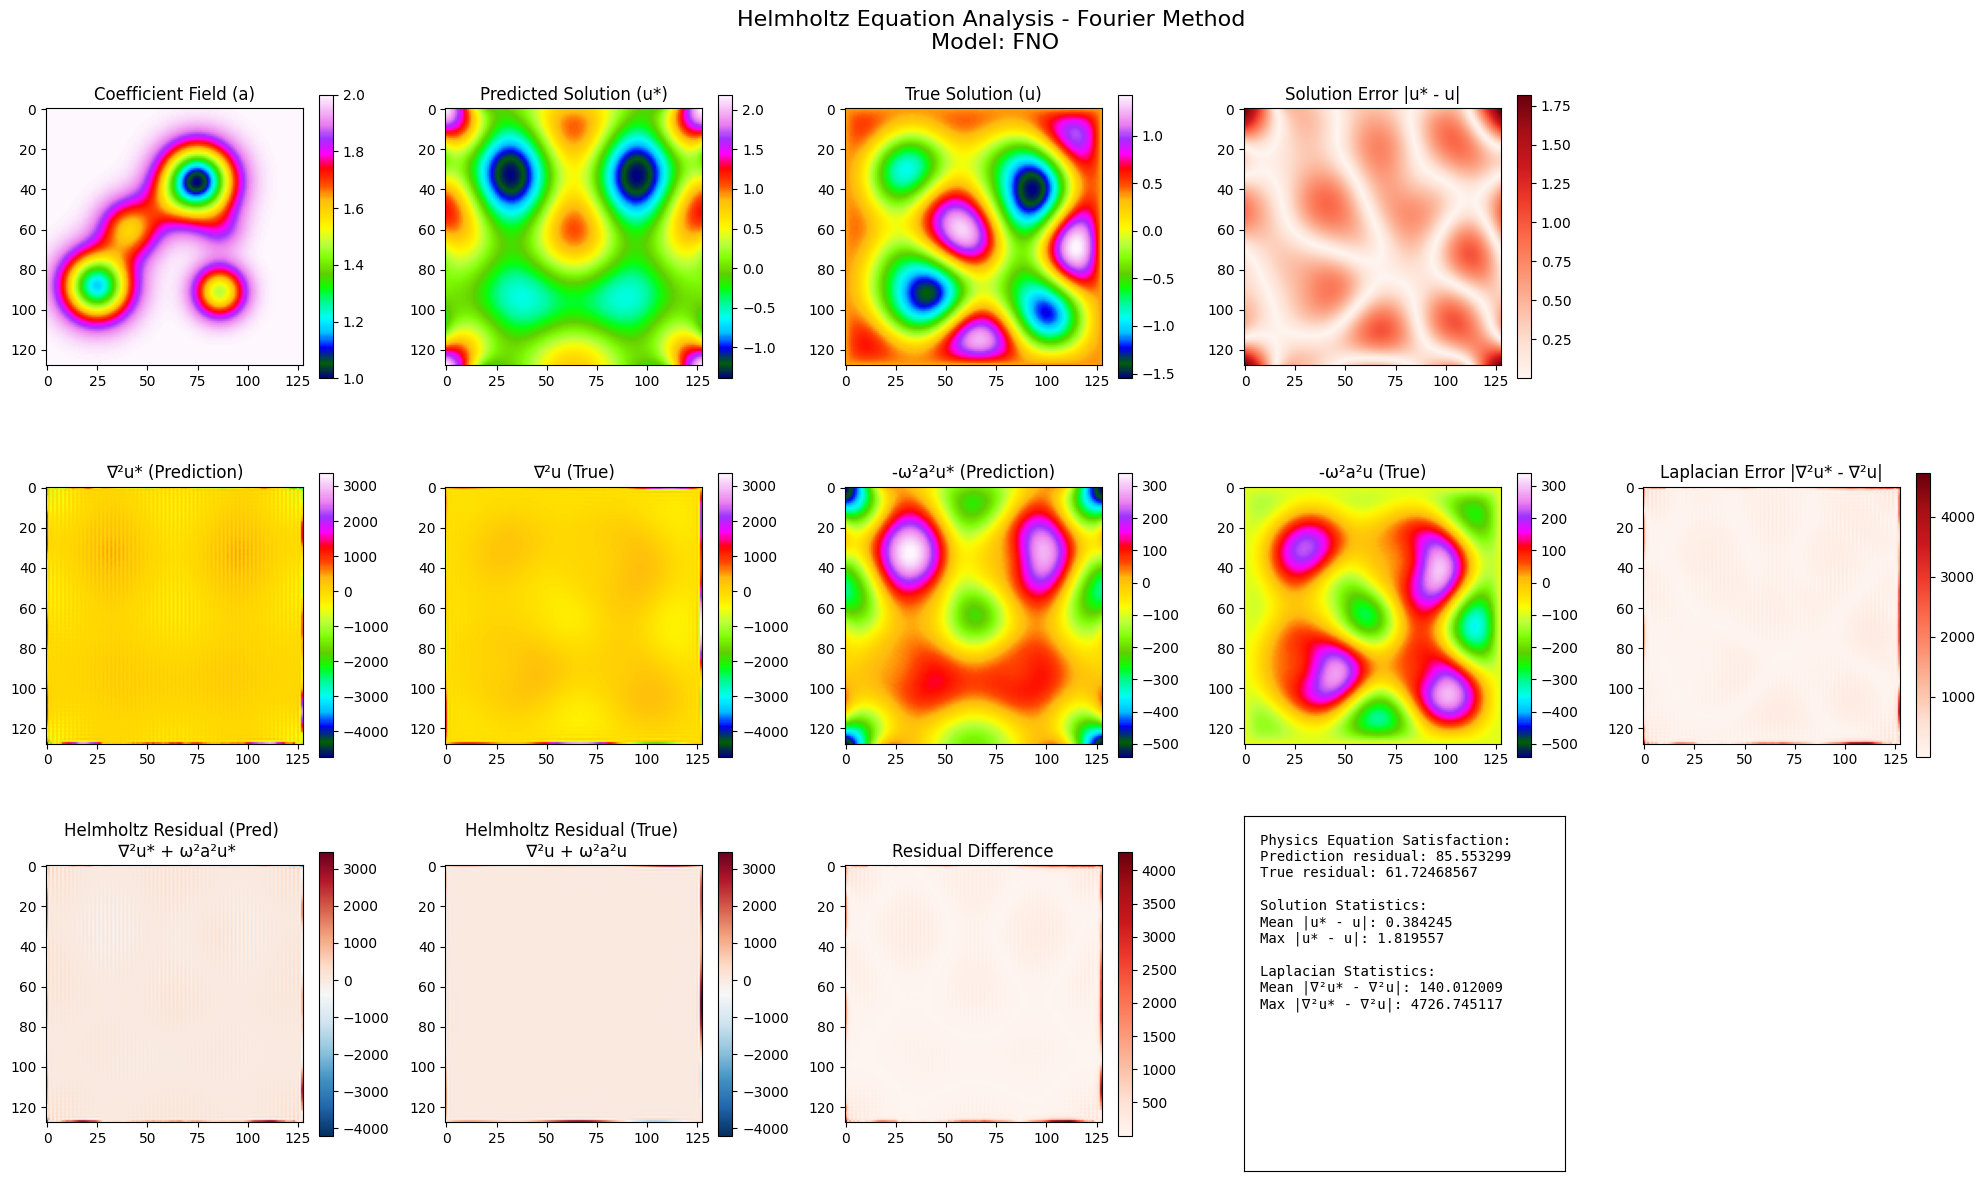

In [15]:
# Visualize physics terms for a single sample
sample_idx = 0
cmap = 'gist_ncar'

"""-------------------------Define Main Variables-------------------------"""
# Coefficient field
coeff_field = a_un[sample_idx].cpu().numpy() # input field (unnormalized: a)

# Solutions
pred_solution = output_pred_un_sq[sample_idx].cpu().numpy() # predicted solution (unnormalized: u*)
true_solution = label_un_sq[sample_idx].cpu().numpy() # ground truth solution (unnormalized: u)

# Laplacians (using Fourier method)
laplacian_pred = laplacian_of_pred[sample_idx].cpu().numpy() # predicted Laplacian (unnormalized: ∇²u*)
laplacian_true = laplacian_of_label[sample_idx].cpu().numpy() # ground truth Laplacian (unnormalized: ∇²u)

# Target terms: -ω²a²u
target_pred = target_term[sample_idx].cpu().numpy() # predicted target term (-ω²a²u*)
target_true = target_term_label[sample_idx].cpu().numpy() # ground truth target term (-ω²a²u)

# Helmholtz residuals: ∇²u - (-ω²a²u) = ∇²u + ω²a²u
residual_pred = helmholtz_residual_pred[sample_idx].cpu().numpy() # predicted residual (unnormalized: ∇²u* + ω²a²u*)
residual_true = helmholtz_residual_label[sample_idx].cpu().numpy() # ground truth residual (unnormalized: ∇²u + ω²a²u)

"""-------------------------Plot Main Variables-------------------------"""
# Create comprehensive visualization
fig, axes = plt.subplots(3, 5, figsize=(20, 12))
fig.suptitle(f"Helmholtz Equation Analysis - Fourier Method \nModel: {model_type}", fontsize=16)

# Row 0: Input components and solutions
im00 = axes[0,0].imshow(coeff_field, cmap=cmap)
axes[0,0].set_title("Coefficient Field (a)")
fig.colorbar(im00, ax=axes[0,0], shrink=0.8)

im01 = axes[0,1].imshow(pred_solution, cmap=cmap)
axes[0,1].set_title("Predicted Solution (u*)")
fig.colorbar(im01, ax=axes[0,1], shrink=0.8)

im02 = axes[0,2].imshow(true_solution, cmap=cmap)
axes[0,2].set_title("True Solution (u)")
fig.colorbar(im02, ax=axes[0,2], shrink=0.8)

# Solution difference
sol_diff = np.abs(pred_solution - true_solution)
im03 = axes[0,3].imshow(sol_diff, cmap='Reds')
axes[0,3].set_title("Solution Error |u* - u|")
fig.colorbar(im03, ax=axes[0,3], shrink=0.8)

# Remove last subplot in first row
axes[0,4].remove()

# Row 1: Laplacians
# Find common scale for Laplacians
vmin_lap = min(laplacian_pred.min(), laplacian_true.min())
vmax_lap = max(laplacian_pred.max(), laplacian_true.max())

im10 = axes[1,0].imshow(laplacian_pred, cmap=cmap, vmin=vmin_lap, vmax=vmax_lap)
axes[1,0].set_title("∇²u* (Prediction)")
fig.colorbar(im10, ax=axes[1,0], shrink=0.8)

im11 = axes[1,1].imshow(laplacian_true, cmap=cmap, vmin=vmin_lap, vmax=vmax_lap)
axes[1,1].set_title("∇²u (True)")
fig.colorbar(im11, ax=axes[1,1], shrink=0.8)

# Target terms
vmin_target = min(target_pred.min(), target_true.min())
vmax_target = max(target_pred.max(), target_true.max())

im12 = axes[1,2].imshow(target_pred, cmap=cmap, vmin=vmin_target, vmax=vmax_target)
axes[1,2].set_title("-ω²a²u* (Prediction)")
fig.colorbar(im12, ax=axes[1,2], shrink=0.8)

im13 = axes[1,3].imshow(target_true, cmap=cmap, vmin=vmin_target, vmax=vmax_target)
axes[1,3].set_title("-ω²a²u (True)")
fig.colorbar(im13, ax=axes[1,3], shrink=0.8)

# Laplacian difference
lap_diff = np.abs(laplacian_pred - laplacian_true)
im14 = axes[1,4].imshow(lap_diff, cmap='Reds')
axes[1,4].set_title("Laplacian Error |∇²u* - ∇²u|")
fig.colorbar(im14, ax=axes[1,4], shrink=0.8)

# Row 2: Helmholtz residuals
vmin_res = min(residual_pred.min(), residual_true.min())
vmax_res = max(residual_pred.max(), residual_true.max())

im20 = axes[2,0].imshow(residual_pred, cmap='RdBu_r', vmin=vmin_res, vmax=vmax_res)
axes[2,0].set_title("Helmholtz Residual (Pred) \n ∇²u* + ω²a²u*")
fig.colorbar(im20, ax=axes[2,0], shrink=0.8)

im21 = axes[2,1].imshow(residual_true, cmap='RdBu_r', vmin=vmin_res, vmax=vmax_res)
axes[2,1].set_title("Helmholtz Residual (True) \n ∇²u + ω²a²u")
fig.colorbar(im21, ax=axes[2,1], shrink=0.8)

# Residual difference
res_diff = np.abs(residual_pred - residual_true)
im22 = axes[2,2].imshow(res_diff, cmap='Reds')
axes[2,2].set_title("Residual Difference")
fig.colorbar(im22, ax=axes[2,2], shrink=0.8)

# Statistics text
stats_text = f"""Physics Equation Satisfaction:
Prediction residual: {pde_error_pred.item():.6f}
True residual: {pde_error_label.item():.8f}

Solution Statistics:
Mean |u* - u|: {sol_diff.mean():.6f}
Max |u* - u|: {sol_diff.max():.6f}

Laplacian Statistics:
Mean |∇²u* - ∇²u|: {lap_diff.mean():.6f}
Max |∇²u* - ∇²u|: {lap_diff.max():.6f}"""

axes[2,3].text(0.05, 0.95, stats_text, transform=axes[2,3].transAxes, fontsize=10, 
               verticalalignment='top', fontfamily='monospace')
axes[2,3].set_xticks([])
axes[2,3].set_yticks([])

# Remove last subplot
axes[2,4].remove()

plt.tight_layout()
plt.show()


## 9. Finite Difference Laplacian Implementation

Now let's implement and test finite difference methods to calculate the Laplacian and compare with the Fourier-based approach. This will help us understand the differences between the two derivative computation methods.


In [16]:
# Import finite difference Laplacian implementation
from FiniteDifferences import Laplace as FiniteDifferenceLaplace

# Initialize finite difference Laplacian operator
# Using 9-point stencil for better accuracy
fd_laplace = FiniteDifferenceLaplace(s=in_size, type="9-point")

print(f"=== Finite Difference Setup ===")
print(f"Grid size: {in_size}")
print(f"Stencil type: 9-point")

# Apply finite difference Laplacian to both prediction and ground truth
# Note: FiniteDifferences expects input with batch dimension
pred_solution_batch = output_pred_un_sq[sample_idx].unsqueeze(0)  # Add batch dimension
true_solution_batch = label_un_sq[sample_idx].unsqueeze(0)       # Add batch dimension

# Calculate Laplacians using finite differences
fd_laplacian_pred, cut_size = fd_laplace(pred_solution_batch)
fd_laplacian_true, cut_size = fd_laplace(true_solution_batch)
# squeeze the batch dimension and convert to numpy
fd_laplacian_pred = fd_laplacian_pred.squeeze(0).cpu().numpy()
fd_laplacian_true = fd_laplacian_true.squeeze(0).cpu().numpy()

print(f"n=== Finite Difference Results ===")
print(f"FD Laplacian prediction shape: {fd_laplacian_pred.shape}")
print(f"FD Laplacian true shape: {fd_laplacian_true.shape}")

if cut_size > 0:
    # Crop the coefficient field and solutions to match finite difference output
    a_cropped = a_un[sample_idx].cpu().numpy()[cut_size:-cut_size, cut_size:-cut_size]
    pred_cropped = output_pred_un_sq[sample_idx].cpu().numpy()[cut_size:-cut_size, cut_size:-cut_size]
    true_cropped = label_un_sq[sample_idx].cpu().numpy()[cut_size:-cut_size, cut_size:-cut_size]
else:
    # No cropping needed
    a_cropped = a_un[sample_idx].cpu().numpy()
    pred_cropped = output_pred_un_sq[sample_idx].cpu().numpy()
    true_cropped = label_un_sq[sample_idx].cpu().numpy()

# Calculate target terms for finite difference case
fd_target_pred = -omega**2 * a_cropped**2 * pred_cropped
fd_target_true = -omega**2 * a_cropped**2 * true_cropped

# Calculate Helmholtz residuals using finite differences
fd_residual_pred = fd_laplacian_pred - fd_target_pred
fd_residual_true = fd_laplacian_true - fd_target_true

# Calculate errors
fd_pde_error_pred = np.mean(np.abs(fd_residual_pred))
fd_pde_error_true = np.mean(np.abs(fd_residual_true))

print(f"n=== Finite Difference Physics Analysis ===")
print(f"Cut size applied: {cut_size}")
print(f"FD Helmholtz residual for prediction: {fd_pde_error_pred:.6f}")
print(f"FD Helmholtz residual for true solution: {fd_pde_error_true:.8f}")

# Compare with Fourier method (need to crop Fourier results to match)
if cut_size > 0:
    fourier_laplacian_pred_cropped = laplacian_pred[cut_size:-cut_size, cut_size:-cut_size]
    fourier_laplacian_true_cropped = laplacian_true[cut_size:-cut_size, cut_size:-cut_size]
else:
    fourier_laplacian_pred_cropped = laplacian_pred
    fourier_laplacian_true_cropped = laplacian_true

# Calculate differences between methods
laplacian_method_diff_pred = np.abs(fd_laplacian_pred - fourier_laplacian_pred_cropped)
laplacian_method_diff_true = np.abs(fd_laplacian_true - fourier_laplacian_true_cropped)

print(f"n=== Method Comparison ===")
print(f"Mean |FD_Laplacian - Fourier_Laplacian| for prediction: {laplacian_method_diff_pred.mean():.6f}")
print(f"Max |FD_Laplacian - Fourier_Laplacian| for prediction: {laplacian_method_diff_pred.max():.6f}")
print(f"Mean |FD_Laplacian - Fourier_Laplacian| for true: {laplacian_method_diff_true.mean():.6f}")
print(f"Max |FD_Laplacian - Fourier_Laplacian| for true: {laplacian_method_diff_true.max():.6f}")


=== Finite Difference Setup ===
Grid size: 128
Stencil type: 9-point
n=== Finite Difference Results ===
FD Laplacian prediction shape: (126, 126)
FD Laplacian true shape: (126, 126)
n=== Finite Difference Physics Analysis ===
Cut size applied: 1
FD Helmholtz residual for prediction: 29.310968
FD Helmholtz residual for true solution: 1.64209759
n=== Method Comparison ===
Mean |FD_Laplacian - Fourier_Laplacian| for prediction: 39.078674
Max |FD_Laplacian - Fourier_Laplacian| for prediction: 718.126831
Mean |FD_Laplacian - Fourier_Laplacian| for true: 12.941246
Max |FD_Laplacian - Fourier_Laplacian| for true: 631.041748


## 10. Comparison Visualization: Fourier vs Finite Difference Methods

Now let's create a comprehensive comparison visualization showing the differences between Fourier and finite difference methods for calculating the Laplacian in the Helmholtz equation context.


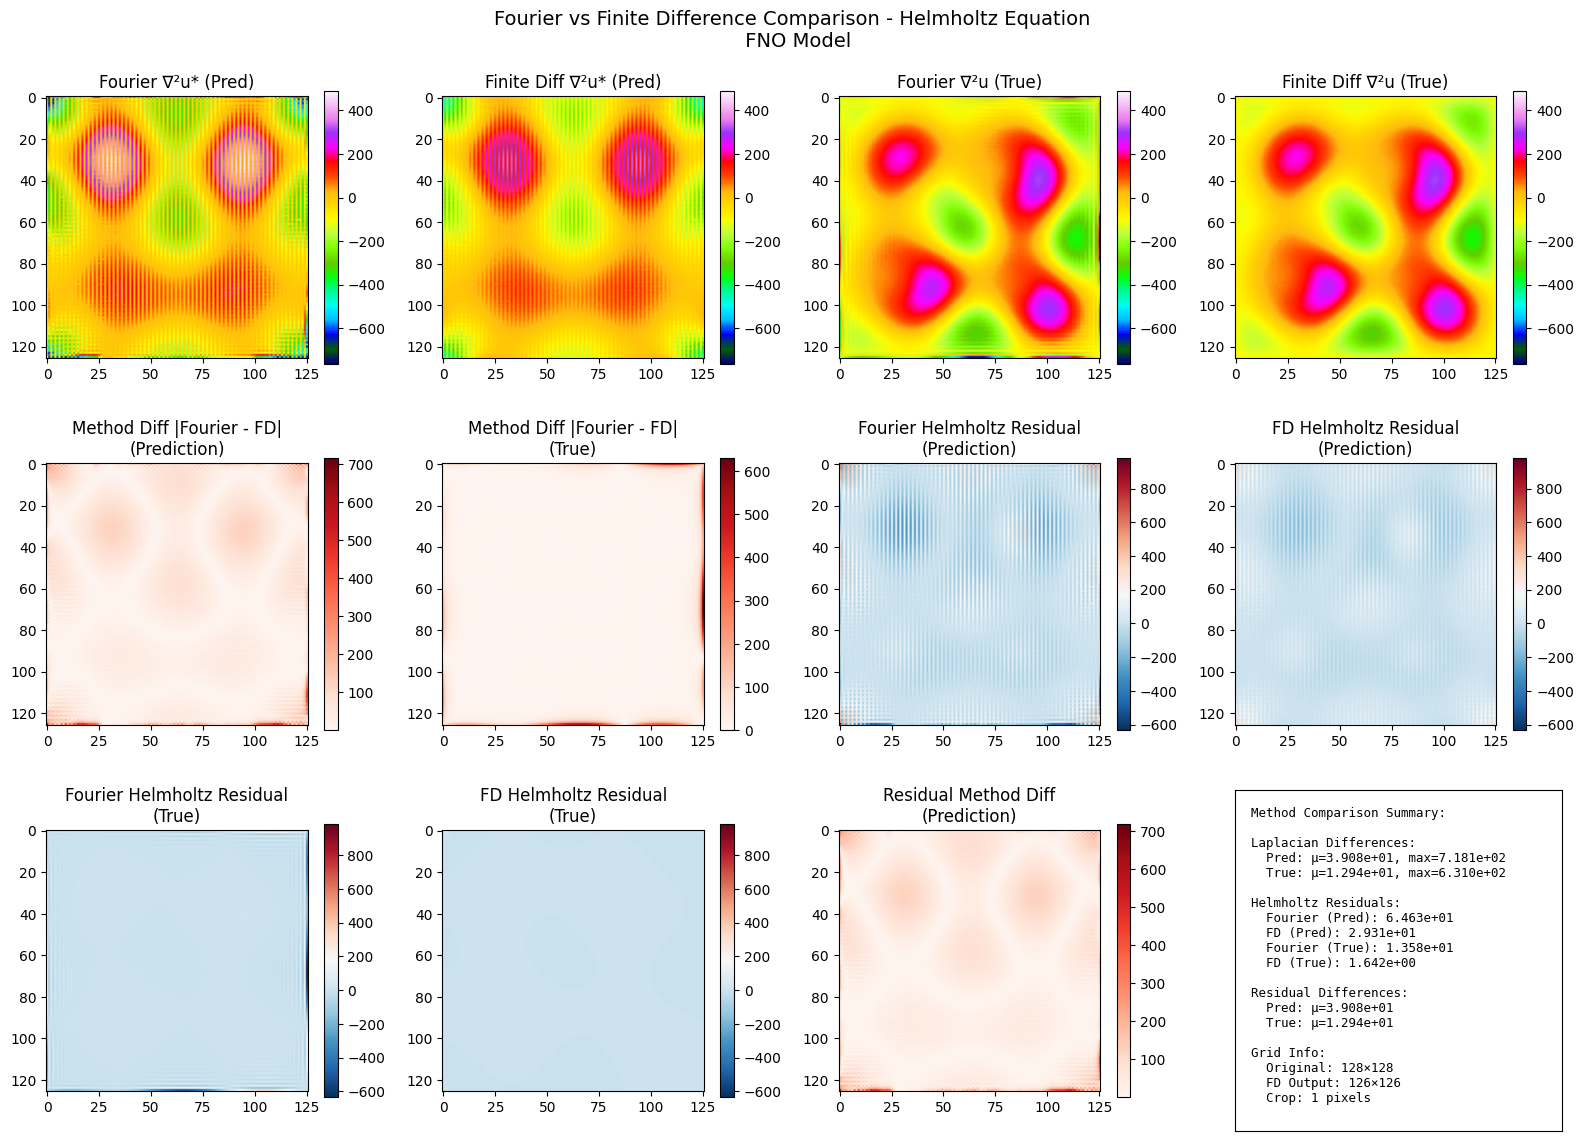

In [17]:
# Create comparison visualization
fig, axes = plt.subplots(3, 4, figsize=(16, 12))
fig.suptitle(f"Fourier vs Finite Difference Comparison - Helmholtz Equation \n {model_type} Model", fontsize=14)

# === Row 0: Laplacian Comparison ===
# Fourier Laplacians
vmin_lap = min(fourier_laplacian_pred_cropped.min(), fourier_laplacian_true_cropped.min(), 
               fd_laplacian_pred.min(), fd_laplacian_true.min())
vmax_lap = max(fourier_laplacian_pred_cropped.max(), fourier_laplacian_true_cropped.max(), 
               fd_laplacian_pred.max(), fd_laplacian_true.max())

im00 = axes[0,0].imshow(fourier_laplacian_pred_cropped, cmap=cmap, vmin=vmin_lap, vmax=vmax_lap)
axes[0,0].set_title("Fourier ∇²u* (Pred)")
fig.colorbar(im00, ax=axes[0,0], shrink=0.8)

im01 = axes[0,1].imshow(fd_laplacian_pred, cmap=cmap, vmin=vmin_lap, vmax=vmax_lap)
axes[0,1].set_title("Finite Diff ∇²u* (Pred)")
fig.colorbar(im01, ax=axes[0,1], shrink=0.8)

im02 = axes[0,2].imshow(fourier_laplacian_true_cropped, cmap=cmap, vmin=vmin_lap, vmax=vmax_lap)
axes[0,2].set_title("Fourier ∇²u (True)")
fig.colorbar(im02, ax=axes[0,2], shrink=0.8)

im03 = axes[0,3].imshow(fd_laplacian_true, cmap=cmap, vmin=vmin_lap, vmax=vmax_lap)
axes[0,3].set_title("Finite Diff ∇²u (True)")
fig.colorbar(im03, ax=axes[0,3], shrink=0.8)

# === Row 1: Method Differences ===
im10 = axes[1,0].imshow(laplacian_method_diff_pred, cmap='Reds')
axes[1,0].set_title("Method Diff |Fourier - FD|\n(Prediction)")
fig.colorbar(im10, ax=axes[1,0], shrink=0.8)

im11 = axes[1,1].imshow(laplacian_method_diff_true, cmap='Reds')
axes[1,1].set_title("Method Diff |Fourier - FD|\n(True)")
fig.colorbar(im11, ax=axes[1,1], shrink=0.8)

# Helmholtz residual comparison
# Fourier residuals (cropped to match FD)
fourier_residual_pred_cropped = residual_pred[cut_size:-cut_size, cut_size:-cut_size] if cut_size > 0 else residual_pred
fourier_residual_true_cropped = residual_true[cut_size:-cut_size, cut_size:-cut_size] if cut_size > 0 else residual_true

vmin_res = min(fourier_residual_pred_cropped.min(), fourier_residual_true_cropped.min(),
               fd_residual_pred.min(), fd_residual_true.min())
vmax_res = max(fourier_residual_pred_cropped.max(), fourier_residual_true_cropped.max(),
               fd_residual_pred.max(), fd_residual_true.max())

im12 = axes[1,2].imshow(fourier_residual_pred_cropped, cmap='RdBu_r', vmin=vmin_res, vmax=vmax_res)
axes[1,2].set_title("Fourier Helmholtz Residual\n(Prediction)")
fig.colorbar(im12, ax=axes[1,2], shrink=0.8)

im13 = axes[1,3].imshow(fd_residual_pred, cmap='RdBu_r', vmin=vmin_res, vmax=vmax_res)
axes[1,3].set_title("FD Helmholtz Residual\n(Prediction)")
fig.colorbar(im13, ax=axes[1,3], shrink=0.8)

# === Row 2: Residual Analysis ===
im20 = axes[2,0].imshow(fourier_residual_true_cropped, cmap='RdBu_r', vmin=vmin_res, vmax=vmax_res)
axes[2,0].set_title("Fourier Helmholtz Residual\n(True)")
fig.colorbar(im20, ax=axes[2,0], shrink=0.8)

im21 = axes[2,1].imshow(fd_residual_true, cmap='RdBu_r', vmin=vmin_res, vmax=vmax_res)
axes[2,1].set_title("FD Helmholtz Residual\n(True)")
fig.colorbar(im21, ax=axes[2,1], shrink=0.8)

# Residual method differences
residual_method_diff_pred = np.abs(fourier_residual_pred_cropped - fd_residual_pred)
residual_method_diff_true = np.abs(fourier_residual_true_cropped - fd_residual_true)

im22 = axes[2,2].imshow(residual_method_diff_pred, cmap='Reds')
axes[2,2].set_title("Residual Method Diff\n(Prediction)")
fig.colorbar(im22, ax=axes[2,2], shrink=0.8)

# Summary statistics
summary_text = f"""Method Comparison Summary:

Laplacian Differences:
  Pred: μ={laplacian_method_diff_pred.mean():.3e}, max={laplacian_method_diff_pred.max():.3e}
  True: μ={laplacian_method_diff_true.mean():.3e}, max={laplacian_method_diff_true.max():.3e}

Helmholtz Residuals:
  Fourier (Pred): {np.mean(np.abs(fourier_residual_pred_cropped)):.3e}
  FD (Pred): {fd_pde_error_pred:.3e}
  Fourier (True): {np.mean(np.abs(fourier_residual_true_cropped)):.3e}
  FD (True): {fd_pde_error_true:.3e}

Residual Differences:
  Pred: μ={residual_method_diff_pred.mean():.3e}
  True: μ={residual_method_diff_true.mean():.3e}

Grid Info:
  Original: {in_size}×{in_size}
  FD Output: {fd_laplacian_pred.shape[0]}×{fd_laplacian_pred.shape[1]}
  Crop: {cut_size} pixels"""

axes[2,3].text(0.05, 0.95, summary_text, transform=axes[2,3].transAxes, fontsize=9, 
               verticalalignment='top', fontfamily='monospace')
axes[2,3].set_xticks([])
axes[2,3].set_yticks([])

plt.tight_layout()
plt.show()


## 11. Evaluate performance of Finite Difference Laplacian

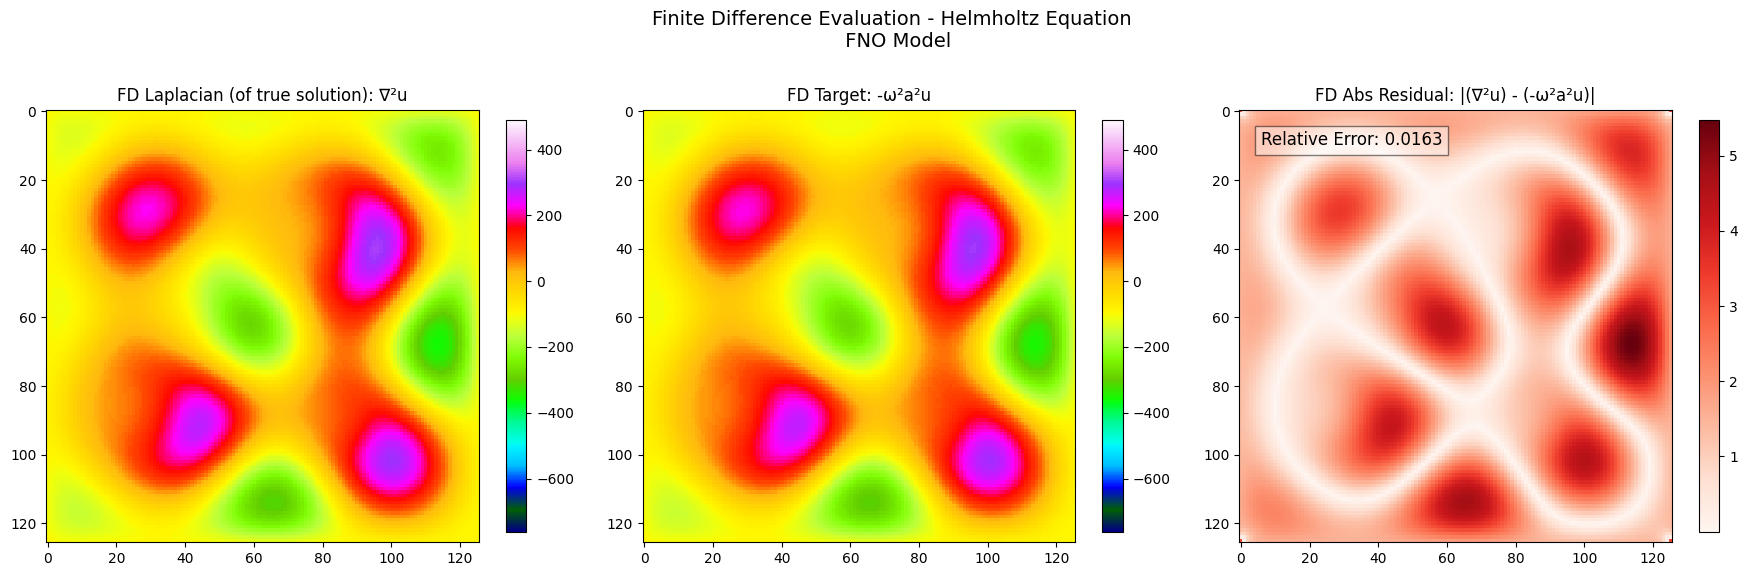

Residual statistics:
  Mean: -0.2542
  Std: 1.9991
  Max: 4.6687
  Min: -5.4694


In [18]:
# plot fd_laplacian_true, fd_target_true, fd_residual_true
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle(f"Finite Difference Evaluation - Helmholtz Equation \n {model_type} Model", fontsize=14)

im00 = axes[0].imshow(fd_laplacian_true, cmap=cmap, vmin=vmin_lap, vmax=vmax_lap)
axes[0].set_title("FD Laplacian (of true solution): ∇²u")
fig.colorbar(im00, ax=axes[0], shrink=0.8)

im01 = axes[1].imshow(fd_target_true, cmap=cmap, vmin=vmin_lap, vmax=vmax_lap)
axes[1].set_title("FD Target: -ω²a²u")
fig.colorbar(im01, ax=axes[1], shrink=0.8)

im02 = axes[2].imshow(np.abs(fd_residual_true), cmap='Reds')
axes[2].set_title("FD Abs Residual: |(∇²u) - (-ω²a²u)|")
fig.colorbar(im02, ax=axes[2], shrink=0.8)
# add relative error text to the top left corner of the residual plot
relative_error = (np.abs(fd_residual_true) / np.abs(fd_target_true)).mean()
axes[2].text(0.05, 0.95, f"Relative Error: {relative_error:.4f}", transform=axes[2].transAxes, fontsize=12, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5))

plt.tight_layout()
plt.show()

print("Residual statistics:")
print(f"  Mean: {fd_residual_true.mean():.4f}")
print(f"  Std: {fd_residual_true.std():.4f}")
print(f"  Max: {fd_residual_true.max():.4f}")
print(f"  Min: {fd_residual_true.min():.4f}")

## 12. Compare Interior Laplacian between Fourier and FD

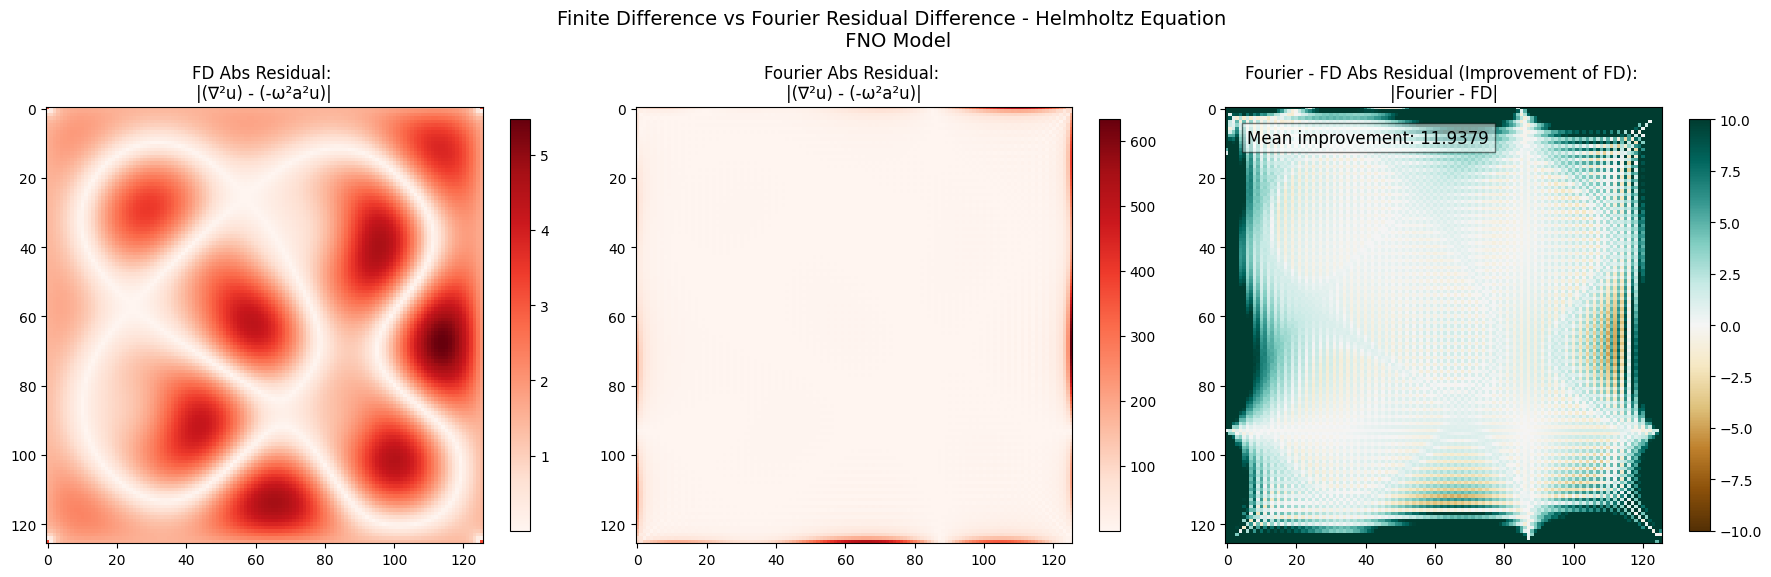

In [19]:
# plot fd_residual_true and fourier_residual_true_cropped and the difference between their absolute values

fd_fourier_residual_diff = np.abs(fourier_residual_true_cropped) - np.abs(fd_residual_true)

# plot fd_fourier_residual_diff
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle(f"Finite Difference vs Fourier Residual Difference - Helmholtz Equation \n {model_type} Model", fontsize=14)

im00 = axes[0].imshow(np.abs(fd_residual_true), cmap='Reds')
axes[0].set_title("FD Abs Residual: \n|(∇²u) - (-ω²a²u)|")
fig.colorbar(im00, ax=axes[0], shrink=0.8)

im01 = axes[1].imshow(np.abs(fourier_residual_true_cropped), cmap='Reds')
axes[1].set_title("Fourier Abs Residual: \n|(∇²u) - (-ω²a²u)|")
fig.colorbar(im01, ax=axes[1], shrink=0.8)

# plot improvement plot (FD - Fourier) but only display values in range -10 to 10
im02 = axes[2].imshow(fd_fourier_residual_diff, cmap='BrBG', vmin=-10,vmax=10)
axes[2].set_title("Fourier - FD Abs Residual (Improvement of FD): \n|Fourier - FD|")
fig.colorbar(im02, ax=axes[2], shrink=0.8)
# calculate the mean of the improvement plot and add it to the top left corner of the plot
axes[2].text(0.05, 0.95, f"Mean improvement: {fd_fourier_residual_diff.mean():.4f}", transform=axes[2].transAxes, fontsize=12, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5))

plt.tight_layout()
plt.show()
